# Programming Exercise 4: Neural Networks Learning

## 1 Neural Networks

## 1.1 Visualizing the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
from scipy.special import expit #Vectorized sigmoid function
from PIL import Image
from scipy import optimize
import itertools

In [2]:
data = scipy.io.loadmat('data/ex4data1.mat')
X, y = data['X'], data['y']
X = np.insert(X, 0, 1, axis=1)
print('X.shape: ', X.shape)
print('y.shape: ', y.shape)
print('Unique elements in y: ', np.unique(y))

X.shape:  (5000, 401)
y.shape:  (5000, 1)
Unique elements in y:  [ 1  2  3  4  5  6  7  8  9 10]


In [3]:
def transformData(line, imgWith=20, imgHeight=20):
    pixel = line[1:].reshape(imgWith, imgHeight)
    return pixel.T

def displayData(imgX=X, rows=10, columns=10, pixelWith=20, pixelHeight=20):
    """展示mat数据图形"""
    displayPic = np.zeros([rows*pixelHeight, columns*pixelWith])
    imageIdx = random.sample(range(imgX.shape[0]), rows*columns)
    for row in range(rows):
        for column in range(columns):
            idx = imageIdx[row*columns+column]
            displayPic[row*pixelWith:(row+1)*pixelWith, column*pixelHeight:(column+1)*pixelHeight] = \
            transformData(imgX[idx])
    
    plt.figure(figsize = (5, 5))
    plt.imshow(displayPic, cmap=cm.Greys_r)

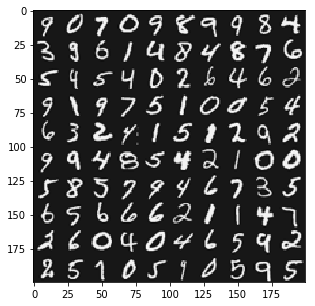

In [4]:
displayData()

## 1.2 Model representation

In [5]:
mat = scipy.io.loadmat('data/ex4weights.mat')
theta_1 = mat['Theta1']
theta_2 = mat['Theta2']
print('theta_1 has shape: ', theta_1.shape)
print('theta_2 has shape: ', theta_2.shape)

theta_1 has shape:  (25, 401)
theta_2 has shape:  (10, 26)


In [6]:
input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10 
n_training_samples = X.shape[0]

In [7]:
def flattenParams(thetas_list):
    flattened_list = [ theta.flatten() for theta in thetas_list ]
    combined = list(itertools.chain.from_iterable(flattened_list))
    assert len(combined) == hidden_layer_size*(input_layer_size+1) + output_layer_size*(hidden_layer_size+1)
    return np.array(combined).reshape([len(combined), 1])

def reshapeParams(flattened_array):
    theta1 = flattened_array[:hidden_layer_size*(input_layer_size+1)].reshape((hidden_layer_size, input_layer_size+1))
    theta2 = flattened_array[hidden_layer_size*(input_layer_size+1):].reshape((output_layer_size, hidden_layer_size+1))
    return [ theta1, theta2 ]

def flattenX(X):
    return np.array(X.flatten()).reshape([n_training_samples*(input_layer_size+1), 1])

def reshapeX(flattenedX):
    return np.array(flattenedX).reshape([n_training_samples, input_layer_size+1])

## 1.3 Feedforward and cost function

In [8]:
def propagateForward(row, thetas):
    features = row.T
    zs_as_per_layer = []
    for i in range(len(thetas)):
        theta = thetas[i]
        z = np.dot(theta, features)
        a = expit(z)
        zs_as_per_layer.append((z, a))
        if i == len(thetas) - 1:
            return np.array(zs_as_per_layer)
        
        a = np.insert(a, 0, 1)
        features = a


def computeCost(thetas_flattened, X_flattened, y, lamb=0.):
    
    thetas = reshapeParams(thetas_flattened)
    
    X = reshapeX(X_flattened)
    
    total_cost = 0.
    
    m = n_training_samples

    for irow in range(m):
        row = X[irow]
        my_hypothesis = propagateForward(row, thetas)[-1][1]
        tmp_y = np.zeros((10, 1))
        tmp_y[y[irow]-1] = 1
        mycost = -tmp_y.T.dot(np.log(my_hypothesis)) - (1-tmp_y.T).dot(np.log(1-my_hypothesis))
        total_cost += mycost
  
    # Normalize the total_cost, cast as float
    total_cost = float(total_cost) / m
    
    # Compute the regularization term
    total_reg = 0.
    for theta in thetas:
        total_reg += np.sum(theta**2)
    total_reg *= float(lamb)/(2*m)

    return total_cost + total_reg

In [9]:
thetas = [theta_1, theta_2]
print(computeCost(flattenParams(thetas), flattenX(X), y))

0.287629165161


## 2 Backpropagation

## 2.1 Sigmoid gradient

In [10]:
def sigmoidGradient(z):
    dummy = expit(z)
    return dummy*(1-dummy)

## 2.2 Random initialization

In [11]:
def randInitializeWeights():
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    rand_thetas = [ np.random.rand( *theta1_shape ) * 2 * epsilon_init - epsilon_init, \
                    np.random.rand( *theta2_shape ) * 2 * epsilon_init - epsilon_init]
    return rand_thetas

## 2.3 Backpropagation

In [12]:
propagateForward(X[0], thetas)

array([[ array([-2.93684669, -2.45058587,  4.95510333,  0.07492977,  0.87241676,
        5.65014719, -4.52318577, -6.41596864,  5.65121414, -3.87156641,
       -2.55955558, -3.81033274, -3.02761383, -2.9383968 , -5.46421117,
        2.06051863,  4.82088856, -2.23170382,  1.71790599,  1.37208071,
       -3.71293077,  4.10936639,  3.56635593,  2.81388641, -2.1195223 ]),
        array([ 0.05036187,  0.07939572,  0.99300197,  0.51872368,  0.70524833,
        0.99649533,  0.01073784,  0.00163257,  0.99649905,  0.02040086,
        0.07178715,  0.02166121,  0.04619385,  0.05028779,  0.00421782,
        0.88700616,  0.99200482,  0.09693938,  0.84785892,  0.79771612,
        0.02382443,  0.98384703,  0.97251796,  0.94342162,  0.10721379])],
       [ array([ -9.09100987,  -6.35139284,  -5.97820432, -10.90296585,
        -4.66162138,  -5.51928622,  -5.19472141,  -7.81998092,
        -5.03242138,   5.45280636]),
        array([  1.12661530e-04,   1.74127856e-03,   2.52696959e-03,
         1.840323

In [13]:
def backPropagate(thetas_flattened, X_flattened, y, lamb=0.):
    
    thetas = reshapeParams(thetas_flattened)
    
    X = reshapeX(X_flattened)

    Delta1 = np.zeros([hidden_layer_size, input_layer_size+1])
    Delta2 = np.zeros([output_layer_size, hidden_layer_size+1])

    # Loop over the training points (rows in myX, already contain bias unit)
    m = n_training_samples
    for irow in range(m):
        row = X[irow]
        a1 = row.reshape([input_layer_size+1, 1])
        
        # propagateForward returns (zs, activations) for each layer excluding the input layer
        temp = propagateForward(row, thetas)
        z2 = np.array(temp[0][0]).reshape(-1, 1)
        a2 = np.array(temp[0][1]).reshape(-1, 1)
        z3 = np.array(temp[1][0]).reshape(-1, 1)
        a3 = np.array(temp[1][1]).reshape(-1, 1)
        
        tmp_y = np.zeros([10, 1])
        tmp_y[y[irow]-1] = 1
        
        delta3 = a3 - tmp_y
        delta2 = np.dot(thetas[1].T[1:, :], delta3)*sigmoidGradient(z2) #remove 0th element
        
        a2 = np.insert(a2, 0, 1, axis=0)
        Delta1 += np.dot(delta2, a1.T) #(25,1)x(1,401) = (25,401) (correct)
        Delta2 += np.dot(delta3, a2.T) #(10,1)x(1,25) = (10,25) (should be 10,26)
        
    D1 = Delta1/float(m)
    D2 = Delta2/float(m)
    
    #Regularization:
    D1[:, 1:] = D1[:, 1:] + (float(lamb)/m)*thetas[0][:,1:]
    D2[:, 1:] = D2[:, 1:] + (float(lamb)/m)*thetas[1][:,1:]
    
    return flattenParams([D1, D2]).flatten()

In [14]:
flattenedD1D2 = backPropagate(flattenParams(thetas), flattenX(X), y, lamb=0.)
D1, D2 = reshapeParams(flattenedD1D2)

## 2.4 Gradient checking

In [15]:
def checkNNGradient(mythetas,myDs,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = flattenParams(mythetas)
    flattenedDs = flattenParams(myDs)
    myX_flattened = flattenX(myX)
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps
        cost_high = computeCost(flattened + epsvec,myX_flattened,myy,mylambda)
        cost_low  = computeCost(flattened - epsvec,myX_flattened,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print("Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."%(x,mygrad,flattenedDs[x]))

In [16]:
checkNNGradient(thetas, [D1, D2], X, y)

Element: 4212. Numerical Gradient = -0.000028. BackProp Gradient = -0.000028.
Element: 9671. Numerical Gradient = 0.000010. BackProp Gradient = 0.000010.
Element: 9341. Numerical Gradient = -0.000144. BackProp Gradient = -0.000144.
Element: 7654. Numerical Gradient = 0.000005. BackProp Gradient = 0.000005.
Element: 8987. Numerical Gradient = -0.000177. BackProp Gradient = -0.000177.
Element: 3317. Numerical Gradient = -0.000078. BackProp Gradient = -0.000078.
Element: 1270. Numerical Gradient = -0.000017. BackProp Gradient = -0.000017.
Element: 4480. Numerical Gradient = -0.000043. BackProp Gradient = -0.000043.
Element: 3186. Numerical Gradient = 0.000000. BackProp Gradient = 0.000000.
Element: 10146. Numerical Gradient = -0.000699. BackProp Gradient = -0.000699.


## 2.5 Regularized Neural Networks